In [1]:
import os
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from keras.models import load_model

file_path = 'hypothetical_pump_failure_dataset.csv'

df = pd.read_csv(file_path)

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df.shape

(1000, 6)

In [3]:
df.head()

,timestamp,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
0,2024-01-01 00:00:00,0.549671,76.996777,93.248217,40.460962,0
1,2024-01-01 01:00:00,0.486174,74.623168,98.554813,45.698075,0
2,2024-01-01 02:00:00,0.564769,70.298152,92.075801,47.931972,0
3,2024-01-01 03:00:00,0.652303,66.765316,96.920385,59.438438,0
4,2024-01-01 04:00:00,0.476585,73.491117,81.063853,52.782766,0


## Missing vaues

In [4]:
df.isnull().sum()

timestamp          0
vibration_level    0
temperature_C      0
pressure_PSI       0
flow_rate_m3h      0
failure            0
dtype: int64

## Summary Statistics:

In [5]:
df.describe()

,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.501933,70.354181,100.058342,49.906404,0.049000
std,0.097922,4.987272,9.834543,5.135663,0.215976
min,0.175873,55.298057,69.804878,35.352757,0.000000
25%,0.435241,66.968792,93.520004,46.312898,0.000000
50%,0.502530,70.315386,99.997492,50.000923,0.000000
75%,0.564794,73.644411,106.609153,53.334727,0.000000
max,0.885273,85.965538,139.262377,66.215465,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   timestamp        1000 non-null   object 
 1   vibration_level  1000 non-null   float64
 2   temperature_C    1000 non-null   float64
 3   pressure_PSI     1000 non-null   float64
 4   flow_rate_m3h    1000 non-null   float64
 5   failure          1000 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


## Class Imbalance:

In [7]:
df.failure.value_counts()

0    951
1     49
Name: failure, dtype: int64

There is a significant imbalance in the target variable, with 951 instances of no failure (label 0) and 49 instances of failure (label 1). This imbalance could impact model performance, so handling it during modeling is crucial.

## Correlation Matrix:

<AxesSubplot:>

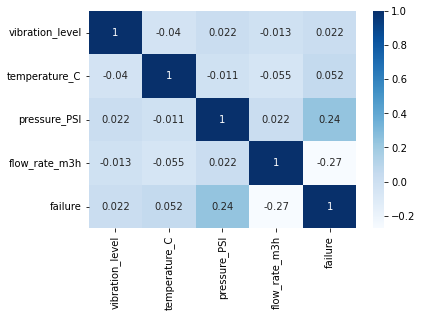

In [8]:
corr = df.iloc[:, 1:].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

pressure, flow rate Level and Failure: Shows a moderate positive correlation, indicating that higher pressure levels may lead to pump failure.

## Distribution

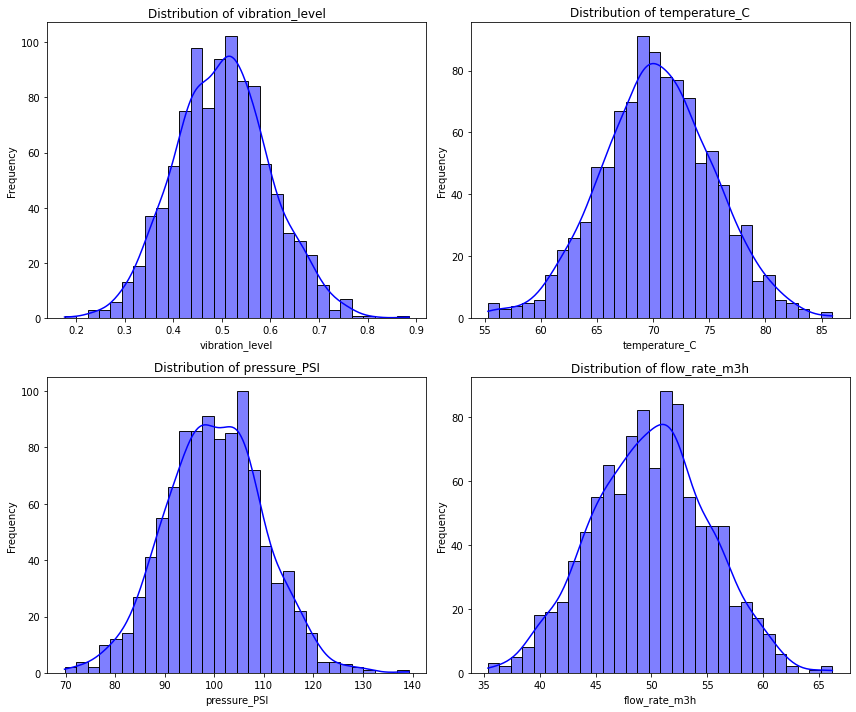

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h']

plt.figure(figsize=(12, 10))

for i, feature in enumerate(features):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
skewness_values = df[['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h']].skew()
print(skewness_values)

vibration_level    0.116976
temperature_C     -0.049396
pressure_PSI       0.061247
flow_rate_m3h     -0.002121
dtype: float64


Vibration Level: The distribution is centered around 0.5 with slight variation, suggesting most pumps experience low to moderate vibration levels, and no extreme outliers are immediately visible.

Temperature (°C): The temperature distribution appears roughly normal, centered around 70°C, with slight variations, suggesting most pumps operate within a narrow temperature range. slight left skewness is visible.

Pressure (PSI): The pressure distribution is also fairly normal, centered around 95 PSI, indicating that most pumps are operating within a standard pressure range, with few instances of extreme high or low pressure.

Flow Rate (m³/h): The flow rate shows a slightly skewed distribution, with most values concentrated between 40 and 60 m³/h. This may indicate that pumps typically operate within a consistent flow range.

## Normalizing/Standardizing the features

In [11]:
df_norm = df.copy()
cols_to_be_norm = df_norm.iloc[:, 1:5].columns.tolist()
print(cols_to_be_norm)

['vibration_level', 'temperature_C', 'pressure_PSI', 'flow_rate_m3h']


In [12]:
scaler = MinMaxScaler()
df_norm[cols_to_be_norm] = scaler.fit_transform(df_norm[cols_to_be_norm])

In [13]:
df_norm

,timestamp,vibration_level,temperature_C,pressure_PSI,flow_rate_m3h,failure
0,2024-01-01 00:00:00,0.526922,0.707548,0.337521,0.165514,0
1,2024-01-01 01:00:00,0.437412,0.630150,0.413921,0.335204,0
2,2024-01-01 02:00:00,0.548204,0.489121,0.320641,0.407586,0
3,2024-01-01 03:00:00,0.671595,0.373922,0.390390,0.780414,0
4,2024-01-01 04:00:00,0.423895,0.593236,0.162099,0.564760,0
...,...,...,...,...,...,...
995,2024-02-11 11:00:00,0.417278,0.653875,0.445883,0.479204,0
996,2024-02-11 12:00:00,0.710312,0.475074,0.471837,0.137972,1
997,2024-02-11 13:00:00,0.547239,0.335618,0.255948,0.422703,0
998,2024-02-11 14:00:00,0.376387,0.452812,0.482840,0.740834,0


## Failure vs Features

<AxesSubplot:xlabel='timestamp'>

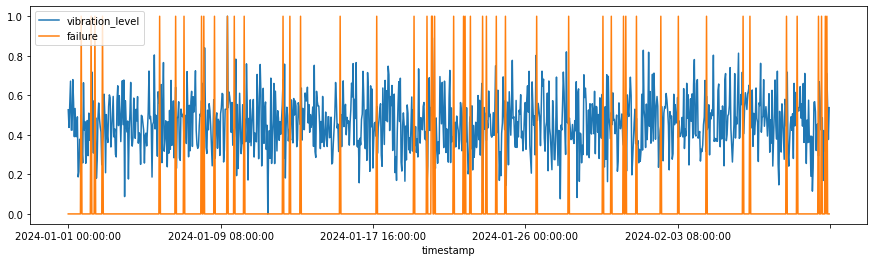

In [14]:
df_norm.plot(x='timestamp',y=['vibration_level', 'failure'], kind='line', figsize =(15,4))

<AxesSubplot:xlabel='timestamp'>

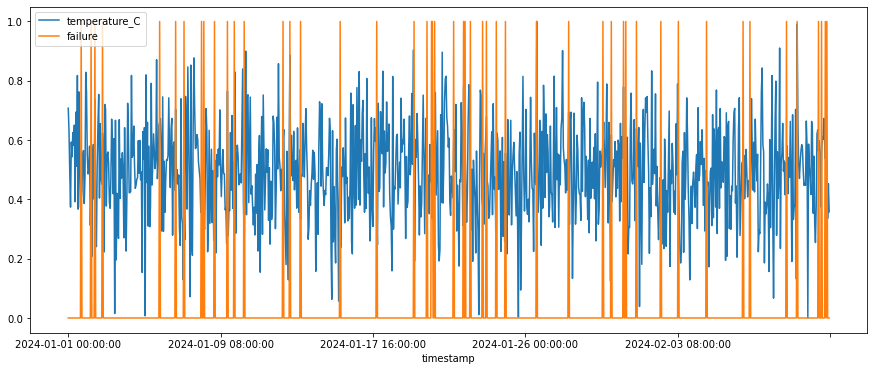

In [15]:
df_norm.plot(x='timestamp',y=[ 'temperature_C', 'failure'], kind='line', figsize =(15,6))

<AxesSubplot:xlabel='timestamp'>

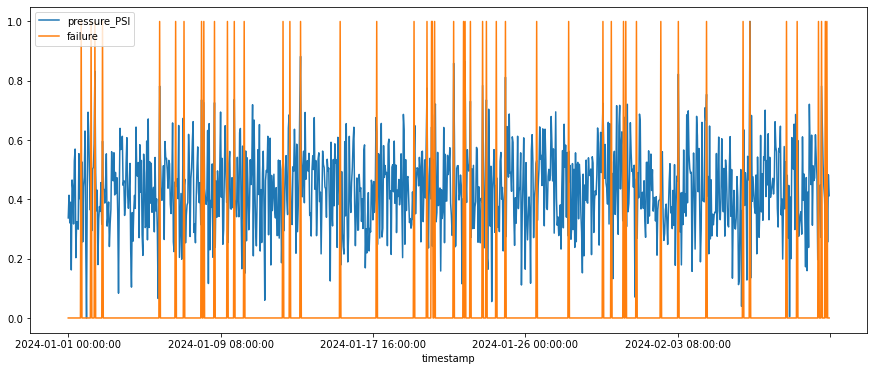

In [16]:
df_norm.plot(x='timestamp',y=[ 'pressure_PSI', 'failure'], kind='line', figsize =(15,6))

<AxesSubplot:xlabel='timestamp'>

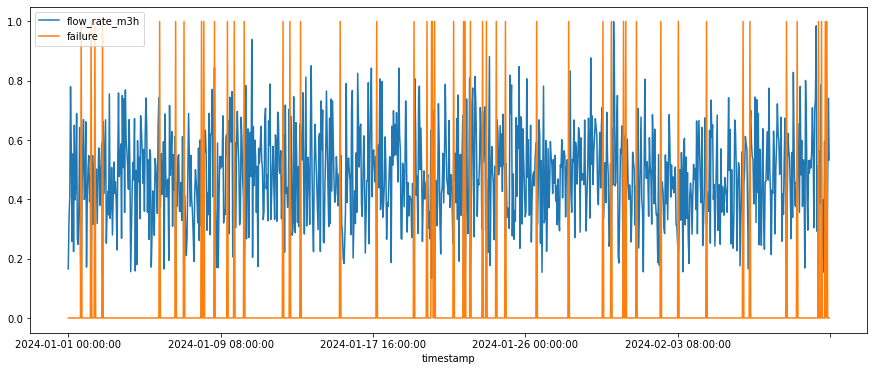

In [17]:
df_norm.plot(x='timestamp',y=[ 'flow_rate_m3h', 'failure'], kind='line', figsize =(15,6))

## Class weight for Imbalanced Dataset

In [18]:
data = df_norm.copy()

In [19]:
X = data[cols_to_be_norm]
Y = data['failure']

sequence_length = 10
step = 1

X_local = list()
Y_local = list()

for start in range(0, len(data) - sequence_length, step):
    end = start + sequence_length
    X_local.append(X[start:end])
    Y_local.append(Y[end-1])

X_local = np.array(X_local)
Y_local = np.array(Y_local)

X_local.shape, Y_local.shape

((990, 10, 4), (990,))

In [20]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(Y), y = Y)
class_weights = dict(zip(np.unique(Y), class_weights))
class_weights

{0: 0.5257623554153522, 1: 10.204081632653061}

In [21]:
model = keras.Sequential()
model.add(LSTM(100, input_shape = (10, 4)))
# model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy"
              , metrics=[keras.metrics.Precision(), keras.metrics.Recall()]
              , optimizer="adam")

model.summary()

D:\anaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,101 (164.46 KB)

 Trainable params: 42,101 (164.46 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
training_size = int(len(X_local) * 0.7)

X_train, y_train = X_local[:training_size], Y_local[:training_size]
X_test, y_test = X_local[training_size:], Y_local[training_size:]

X_train.shape, y_train.shape,X_test.shape, y_test.shape

NameError: name 'X_local' is not defined

In [23]:
# X_train, y_train,X_test, y_test = train_test_split(X_local,Y_local, test_size=0.2)
# X_train.shape, y_train.shape,X_test.shape, y_test.shape

In [24]:
model.fit(X_train, y_train, batch_size=32, epochs=50, class_weight=class_weights)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7442 - precision: 0.0462 - recall: 0.7599        
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7426 - precision: 0.0785 - recall: 0.1929         
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7358 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6309 - precision: 0.0000e+00 - recall: 0.0000e+00 
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6563 - precision: 0.1092 - recall: 0.5823         
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7004 - precision: 0.1652 - recall: 0.8747
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6998 - precision: 0.1766 - recall: 0.5901 
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7487 - precision: 0.2626 - recall: 0.5768 
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6203 - precision: 0.4322 - recall: 0.2876 
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━

In [25]:
response = model.evaluate(X_test, y_test)
y_test_pred = np.where(model.predict(X_test) > 0.5, 1, 0)
report = classification_report(y_test,y_test_pred)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.3935 - precision: 0.1893 - recall: 0.6111
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [26]:
print(report)

              precision    recall  f1-score   support

           0       0.98      0.85      0.91       281
           1       0.19      0.62      0.29        16

    accuracy                           0.84       297
   macro avg       0.58      0.74      0.60       297
weighted avg       0.93      0.84      0.87       297



In [27]:
model.save('my_model.h5')

In [2]:
loaded_model = load_model('my_model.h5')

In [3]:
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          42,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,103 (164.47 KB)

 Trainable params: 42,101 (164.46 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [20]:
SEQUENCE_LENGTH = 10
TARGET ='failure'